# HEROS: Demonstration Notebook
This notebook is set up as a demonstration for running the HEROS algorithm on different example datasets (with a binary outcome). This major sections of this notebook includes the following:
* Notebook Run Parameters
* Package Imports and Folder Management
* Example Data Setup
* Load and Prepare Training Dataset (including expert knowledge score generation - optionally used by HEROS)
* Run HEROS (Training)
* Testing Data Evaluation (focused on the top model from the model Pareto-front automatically chosen by the recommended strategy)
* Visualize Top Model (i.e. Rule-Set) For Interetation
* Calculating Top Model Feature Importance Estimates
* Example Prediction Reasoning Explanation (With Top Model)
* Visualize Rule and Model Population Pareto Fronts
* Saving Rule and Model Populations as Output
* Save and Visualize Learning Performance across Phase I and Phase 2 Training Iterations
* Saving Other Outputs
* Visual Interpretation and Predictions With the Whole Phase I Rule Population
* Testing Evaluation with Top Default Model or Custom Selected Model
* Evaluation of Stored Rule Populations (At User-Specified Iteration Checkpoints)
* Evaluation of Stored Top Model (At User-Specified Iteration Checkpoints)

## Example Dataset Options
### **MUX6: (6-bit Multiplexer Dataset)**
Prior to 90/10 partitioning (into train/test sets), included 500 instances (not all unique) and 6 total features (all predictive) with no noise (i.e. an trained model is capable of predicting with 100% accuracy). Features A_0 and A_1 are 'address-bits' that are predictive for every instance. Features R_0, R_1, R_2, and R_3 are 'register-bits' that are predictive for about 1/4 of all instances, each. All features and outcome (i.e. 'class') are binary-valued, and there are no missing values. MUX datasets involved feature interactions and heterogeneous patters of association. 
### **MUX11: (11-bit Multiplexer Dataset)**
Prior to 90/10 partitioning, included 5000 instances and 11 total features (all predictive) with no noise. Features A_0, A_1, and A_2 are 'address-bits', while the rest are register bits.
### **MUX20: (20-bit Multiplexer Dataset)**
Prior to 90/10 partitioning, included 10000 instances and 20 total features (all predictive) with no noise. Features A_0, A_1, A_2, and A_3 are 'address-bits', while the rest are register bits.
### **GAM_A: (GAMETES Simulated Dataset A - 4 Additive Univariate Features)**
Prior to 90/10 partitioning, included 1600 instances and 100 total features (4 are predictive - M0P0, M1P0, M2P0, M3P0) with a small degree of overall simulated noise. Each feature has a univariate association with outcome, with the strongest association being an additive combination of all 4 predictive features. Outcome (i.e. 'Class') is binary-valued.
### **GAM_C: (GAMETES Simulated Dataset C - 2-way Epistatic Interaction)**
Prior to 90/10 partitioning, included 1600 instances and 100 total features (2 are predictive - M0P0, M0P1) with about 60% simulated noise. Both predictive features have low/no univariate association with outcome. Outcome (i.e. 'Class') is binary-valued.
### **GAM_E: (GAMETES Simulated Dataset E - 4 Heterogeneous Univariate Features)**
Prior to 90/10 partitioning, included 1600 instances and 100 total features (2 are predictive - M0P0, M0P1) with about 60% simulated noise. Both predictive features have low/no univariate association with outcome. Outcome (i.e. 'Class') is binary-valued.

***
## Notebook Run Parameters
The parameters below control basic notebook functionality and allow users to change other HEROS run parameters for this demonstration.

In [ ]:
# Notebook Operation Parameters ---------------------------------------------------------------------------------
load_from_cloned_repo = True # Leave True if running from cloned repository, and change to False if relying on 'pip' installation of HEROS
local_save = True # If True, saves output in pre-designated local folder within cloned repository folder
folder_path = './output' # Specify new path for output files generated by this notebook (if local_save = False)
run_all_cells = True # If True, run all cells of notebook (i.e. generate all example outputs and visualizations). False will only run key cells

# Specify which example dataset to run --------------------------------------------------------------------------
example_dataset = 'GAM_C' # 'MUX6' # Dataset Options: 'MUX6', 'MUX11', 'MUX20', 'GAM_A', 'GAM_C', 'GAM_E'

# Expert Knowldge Generation Run Parameters ---------------------------------------------------------------------
max_instances = 2000 # Maximum number of available training instances to use in estimating feature importance scores with 'MultiSURF' algorithm.
use_turf = False # Idicate whether to use TuRF wrapper algorithm in combination with MultiSURF (recommended for large feature spaces, e.g. > 10000 features)
turf_pct = 0.2 # Controls the number of TuRF iterations as well as the number of features removed from calculations each iteration. (0.2 runs for 5 iterations with 20% of bottom scoring features removed each time)

# HEROS Key Hyperparameters -------------------------------------------------------------------------------------
iterations = 50000 # (Rule_I) Number of Phase I learning iterations (e.g. 50000)
pop_size = 500 # (Rule_P) Maximum size of Phase I rule population (micro-population size) (e.g. 500)
model_iterations = 100 # (Model_I) Number of Phase II learning iterations (e.g. 100)
model_pop_size = 100 # (Model_P) Maximum size of Phase II model population (e.g. 100)
nu = 1 # (v) Accuracy pressure (1 is neutral)

# Other HEROS Hyperparameters -----------------------------------------------------------------------------------
beta = 0.2 # (B) Average {M} size learning rate
theta_sel = 0.5 # (0_sel) {M} proportion for Phase I tournament selection
cross_prob = 0.8 # (p_cross) probability of applying crossover (Phase I and II)
mut_prob = 0.04 # (p_mut) probability of applying mutation (Phase I and II)
merge_prob = 0.1 # (p_merge) probability of applying merge (Phase II)
new_gen = 1.0 # Controls size of {OMP} as function of Model_P
model_pop_init = 'target_acc' # Model initialization method ('random' or 'target_acc')
subsumption = 'both' # Use GA, {C} or 'both' subsumption mechanisms ('ga', or 'c', 'both', or None)
rsl = 0 # Manually specify rule specificity limit (Give positive integer or leave 0 for automatic rule specificity limit determination from dataset properties)
compaction = 'sub' # rule compaction method ('sub' or None)
random_state = 42 # Applied random seed (for reproducibility)

# HEROS Performance tracking hyperparameters --------------------------------------------------------------------
track_performance = 1000 # Number of Phase I iterations where performance metrics are periodically estimated
model_tracking = True # Track top model performance across training iterations
stored_rule_iterations = '500,1000,5000,10000,50000' # Specified Phase I iterations where the current rule {P} is archived for external evaluation (e.g. '500,1000,5000,10000' or None)
stored_model_iterations = '10,50,100' # Specified Phase II iterations where the current {MP} is archived for external evaluation (e.g. '10,50,100', or None)
verbose = True # Run in 'verbose' mode - display run details

# In-Development HEROS Hyperparameters (Recommend not changing) -------------------------------------------------
outcome_type = 'class' # Only 'class' (i.e. classification outcome) is operational in current implementation
fitness_function = 'pareto' # Fitness function for Phase I rule discovery ('accuracy' or 'pareto') Pareto is strongly recommended unless analyzing clean problems.
feat_track = 'end' # Feature tracking strategy applied (None, 'add', 'wh', 'end') Experimental - recommended to leave to None
rule_pop_init = None # Specifies rule population pre-initialization method (None, 'load', or 'dt') Experimental - recommended to leave to None


# Visualization Parameters ------------------------------------------------------------------------------------
output_to_pdf = True # If True, output visualizations to PDF


***
## Package Imports & Folder Management:

In [2]:
# Load heros algorithm ---------------------------------------------------------
if load_from_cloned_repo: # Load HEROS algorithm locally from cloned github repository
    from src.skheros.heros import HEROS
else: # Load HEROS Notebook via pip installation
    from skheros.heros import HEROS

# Load all other packages used in this notebook --------------------------------
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skrebate import MultiSURF, TURF # Install using: pip install skrebate==0.7
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score

# Load visualization packages ------------------------------------------------
from matplotlib.backends.backend_pdf import PdfPages 
from groq import Groq
import textwrap


# Determine notebook output folder path ------------------------------------------------------
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
if local_save:
    output_path = './output'
else:
    output_path = folder_path

# Report current working directory ---------------------------------------------
current_working_directory = os.getcwd()
print(current_working_directory)

/Users/khoidinh/Documents/coding/scikit-heros


In [3]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

class PDFCollector:
    """
    Monkey-patches plt.show/plt.close with standalone wrapper functions
    that capture every figure, and then dump them into one PDF.
    """
    def __init__(self):
        self._closed = []
        self._orig_show = plt.show
        self._orig_close = plt.close

    def patch(self):
        orig_show  = self._orig_show
        orig_close = self._orig_close
        closed     = self._closed

        # --- show wrapper ---
        def show_wrapper(*args, **kwargs):
            # capture all open figures just before they get closed/displayed
            for num in plt.get_fignums():
                closed.append(plt.figure(num))
            return orig_show(*args, **kwargs)

        # preserve the original signature so inline-backend is happy
        try:
            show_wrapper.__signature__ = orig_show.__signature__
        except Exception:
            pass

        # --- close wrapper ---
        def close_wrapper(fig=None):
            # inline backend sometimes calls close(True/False)
            if isinstance(fig, bool):
                return orig_close(fig)

            # capture everything if fig is None
            if fig is None:
                for n in plt.get_fignums():
                    closed.append(plt.figure(n))
            elif isinstance(fig, plt.Figure):
                closed.append(fig)
            elif isinstance(fig, int):
                closed.append(plt.figure(fig))

            return orig_close(fig)

        try:
            close_wrapper.__signature__ = orig_close.__signature__
        except Exception:
            pass

        # apply our patch
        plt.show  = show_wrapper
        plt.close = close_wrapper

    def restore(self):
        """Put back the original plt.show/plt.close."""
        plt.show  = self._orig_show
        plt.close = self._orig_close

    def save_pdf(self, path: str):
        """Write all captured + currently open figures into one PDF."""
        with PdfPages(path) as pdf:
            # cover page
            fig = plt.figure(figsize=(8,6))
            fig.text(0.5, 0.5, 'Visualization Report', ha='center', va='center', fontsize=24)
            pdf.savefig(fig)
            plt.close(fig)

            # currently open figures
            for num in plt.get_fignums():
                pdf.savefig(plt.figure(num))
            # all the ones that got closed
            for fig in self._closed:
                try:
                    pdf.savefig(fig)
                except Exception:
                    pass

        print(f"📄 All figures saved to {path}")


In [4]:
collector = PDFCollector()
collector._closed.clear()
collector.patch()

***
## Example Data Setup
Sets up the various options for each possible example dataset (as selected above by the user).

In [5]:
#Initialize dataset parameters
train_data_path = None
test_data_path = None
outcome_label = 'Class' # Class/outcome column label in target dataset
instanceID_label = 'InstanceID' #None for datasets without an instance ID column
excluded_column = None

if example_dataset == 'MUX6': # 6-bit Multiplexer
    train_data_path = 'evaluation/datasets/partitioned/multiplexer/A_multiplexer_6_bit_500_inst_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/multiplexer/A_multiplexer_6_bit_500_inst_CV_Test_1.txt'
    excluded_column = 'Group'
elif example_dataset == 'MUX11': # 11-bit Multiplexer
    train_data_path = 'evaluation/datasets/partitioned/multiplexer/B_multiplexer_11_bit_5000_inst_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/multiplexer/B_multiplexer_11_bit_5000_inst_CV_Test_1.txt'
    excluded_column = 'Group'
elif example_dataset == 'MUX20': # 20-bit Multiplexer
    train_data_path = 'evaluation/datasets/partitioned/multiplexer/C_multiplexer_20_bit_10000_inst_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/multiplexer/C_multiplexer_20_bit_10000_inst_CV_Test_1.txt'
    excluded_column = 'Group'
elif example_dataset == 'GAM_A': # GAMETES Dataset A (additive)
    train_data_path = 'evaluation/datasets/partitioned/gametes/A_uni_4add_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/gametes/A_uni_4add_CV_Test_1.txt'
elif example_dataset == 'GAM_C': # GAMETES Dataset C (epistasis)
    train_data_path = 'evaluation/datasets/partitioned/gametes/C_2way_epistasis_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/gametes/C_2way_epistasis_CV_Test_1.txt'
elif example_dataset == 'GAM_E': # GAMETES Dataset E (heterogeneous)
    train_data_path = 'evaluation/datasets/partitioned/gametes/E_uni_4het_CV_Train_1.txt'
    test_data_path = 'evaluation/datasets/partitioned/gametes/E_uni_4het_CV_Test_1.txt'
    excluded_column = 'Model'
else:
    print("Specified Example Dataset Not Found!")

***
## Load and Prepare Training Dataset
Data used for training HEROS has the following requirements:
1. The training data must be passed as separate array-like objects including:
    1. 'X' {n_samples, n_features} Training instance features.
    3. 'y' {n_samples} Training labels of the outcome variable.
3. 'y must always be provided and must not include any missing values.
4. Missing values are allowed in 'X' but data instances should be excluded that have missing values for all features. Note, HEROS treats missing values as missing, i.e. no imputation of values are made or needed. Any rule that specifies a given feature will not match an instance with a missing value at that instance. 

Required data preparation here includes separating the loaded dataset into X and y array-like objects, and removing unnecessary columns. 

In [6]:
# Load training dataset ------------------------
train_df = pd.read_csv(train_data_path, sep="\t")
print(train_df.head())

# Create unique output folder for specific target dataset ------------------------
file_name = os.path.splitext(os.path.basename(train_data_path))[0]
output_path = output_path+'/'+file_name
if not os.path.exists(output_path):
        os.makedirs(output_path)

#Prepare Training Data ------------------------
try:
    X = train_df.drop(excluded_column, axis=1) #Remove excluded column from consideration in this notebook
except:
    X = train_df
    print('Excluded column not available')
try:
    X = X.drop(instanceID_label,axis=1)
except:
    print('Instance ID coulmn not available')

X = X.drop(outcome_label, axis=1)
feature_names = X.columns 
cat_feat_indexes = list(range(X.shape[1])) #all feature are treated as categorical so provide indexes 0-5 in this list for 6-bit multiplexer dataset e.g. [0,1,2,3,4,5]

#Finalize separate array-like objects for X and y
X = X.values
y = train_df[outcome_label].values #outcome values
try:
    row_id = train_df[instanceID_label].values #instance id values
except:
    row_id = None

   N0  N1  N2  N3  N4  N5  N6  N7  N8  N9  ...  N91  N92  N93  N94  N95  M0P0  \
0   1   1   0   0   0   0   0   0   1   0  ...    1    1    1    0    1     0   
1   0   0   0   0   0   0   0   0   0   0  ...    1    0    0    0    0     1   
2   0   2   0   1   1   0   0   1   0   1  ...    0    0    0    0    1     1   
3   0   0   0   1   0   0   0   0   0   0  ...    1    1    1    1    0     0   
4   0   1   0   0   1   1   0   2   0   1  ...    0    2    0    0    0     1   

   M1P0  M2P0  M3P0  Class  
0     1     1     1      1  
1     1     1     1      1  
2     2     0     0      1  
3     0     1     1      1  
4     1     0     0      1  

[5 rows x 101 columns]
Excluded column not available
Instance ID coulmn not available


### Generate Expert Knowlege Scores for Features (Optional, but suggested in HEROS) 
Previous LCS research has indicated that using Relief-based algorithms such as 'MultiSURF' to generate feature importance scores as a guide for rule initialization improves evolutionary algorithm performance. Here we show how these scores can be generated, saved, and later used by HEROS for rule initialization. 

These scores only need to be generated once for a given training dataset and then can be saved for future use. This code only runs MultiSURF if the scores have not yet been generated for a training dataset with a unique name.

The MultiSURF (feature importance estimation) algorithm is found in our scikit-rebate respository at https://github.com/UrbsLab/scikit-rebate. 

In [7]:
def balanced_sampling(df,outcome_label, max_instances):
    """ Returns a dataframe with a sampled number of rows from the original (retaining class balance if possible).
        Assumes that outcome values are either 0 or 1. """
    # Split the DataFrame by class
    df_class_0 = df[df[outcome_label] == 0]
    df_class_1 = df[df[outcome_label] == 1]
    # Determine the number of rows to sample per class
    n_class_0 = max_instances // 2
    n_class_1 = max_instances - n_class_0  # Assign remaining rows to Class 1
    # Ensure we don't sample more rows than available
    n_class_0 = min(n_class_0, len(df_class_0))
    n_class_1 = min(n_class_1, len(df_class_1))
    # Sample rows from each class
    sampled_class_0 = df_class_0.sample(n=n_class_0, replace=False)
    sampled_class_1 = df_class_1.sample(n=n_class_1, replace=False)
    # Combine the sampled rows
    sampled_df = pd.concat([sampled_class_0, sampled_class_1]).reset_index(drop=True)
    return sampled_df

In [8]:
# Further data preparation for expert knowldge generation (i.e. balanced subsampling of training instances for faster run times)
fs_train_df = balanced_sampling(train_df, outcome_label, max_instances)
try:
    fs_X = fs_train_df.drop(excluded_column, axis=1) #Remove excluded column from consideration in this notebook
except:
    fs_X = fs_train_df
    print('Excluded column not available')
try:
    fs_X = fs_X.drop(instanceID_label,axis=1)
except:
    print('Instance ID coulmn not available')
fs_X = fs_X.drop(outcome_label, axis=1)
#Finalize separate array-like objects for X and y
fs_X = fs_X.values
fs_y = fs_train_df[outcome_label].values #outcome values
#Optional TURF Parameters --------------
num_scores_to_return = int(X.shape[1]/2.0)
# --------------------------------------
score_path_name = None
if use_turf:
    score_path_name = output_path+'/MultiSURF_TuRF_Scores.csv' #No need to change
else:
    score_path_name = output_path+'/MultiSURF_Scores.csv' #No need to change
# Calculate or load feature importance estimates with MultiSURF or MultiSURF+TuRF ------------------------------------
if not os.path.isfile(score_path_name):
    if use_turf: # Run MultiSURF with TuRF wrapper
        print("Generating MultiSURF/TuRF Scores:")
        clf = TURF(MultiSURF(n_jobs=None), pct=turf_pct, num_scores_to_return=num_scores_to_return).fit(fs_X, fs_y)
        ek = clf.feature_importances_
        score_data = pd.DataFrame({'Feature':feature_names,'Score':ek})
        score_data.to_csv(score_path_name,index=False)
    else: #Just run MultiSURF
        print("Generating MultiSURF Scores:")
        clf = MultiSURF(n_jobs=None).fit(fs_X, fs_y)
        ek = clf.feature_importances_
        score_data = pd.DataFrame({'Feature':feature_names,'Score':ek})
        score_data.to_csv(score_path_name,index=False)
else: #load previously trained scores
    print("Loading MultiSURF Scores")
    loaded_data = pd.read_csv(score_path_name)
    ek = loaded_data['Score'].tolist()
print(list(feature_names))
print(ek)

Excluded column not available
Instance ID coulmn not available
Loading MultiSURF Scores
['N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32', 'N33', 'N34', 'N35', 'N36', 'N37', 'N38', 'N39', 'N40', 'N41', 'N42', 'N43', 'N44', 'N45', 'N46', 'N47', 'N48', 'N49', 'N50', 'N51', 'N52', 'N53', 'N54', 'N55', 'N56', 'N57', 'N58', 'N59', 'N60', 'N61', 'N62', 'N63', 'N64', 'N65', 'N66', 'N67', 'N68', 'N69', 'N70', 'N71', 'N72', 'N73', 'N74', 'N75', 'N76', 'N77', 'N78', 'N79', 'N80', 'N81', 'N82', 'N83', 'N84', 'N85', 'N86', 'N87', 'N88', 'N89', 'N90', 'N91', 'N92', 'N93', 'N94', 'N95', 'M0P0', 'M1P0', 'M2P0', 'M3P0']
[-0.0106588674866745, -0.0149517280092865, -0.0087890470808815, -0.0095024949023677, -0.0156421714882316, -0.0102228088097565, -0.0031129491444291, -0.0057306456513251, -0.0126769481602078, -0.018410255820002, -0.0140

***
## Run HEROS (Training)

1. (OPTIONAL) 'pop_df' is a DataFrame of a previously trained HEROS rule population that can be uploaded to initialize a new HEROS run.
2. (OPTIONAL) 'ek' is a numpy array or list of expert knowledge weights for all quantitative and categorical features in the dataset. They must be formatted as follows:
    1. This list must have the same number of elements as there are total features in the dataset (ordered in the same way)
    2. If a mix of quantiative and categorical features are loaded, HEROS will combine them with all quantitative features first, followed by all categorical features in the same order as provided in 'X' or 'Xc'.

In [9]:
# Initialize HEROS algorithm with run parameters
heros = HEROS(outcome_type=outcome_type,iterations=iterations,pop_size=pop_size,cross_prob=cross_prob,mut_prob=mut_prob,nu=nu,beta=beta,theta_sel=theta_sel,
              fitness_function=fitness_function,subsumption=subsumption,rsl=rsl,feat_track=feat_track, model_iterations=model_iterations,
              model_pop_size=model_pop_size,model_pop_init=model_pop_init,new_gen=new_gen,merge_prob=merge_prob,rule_pop_init=rule_pop_init,compaction=compaction,
              track_performance=track_performance,model_tracking=model_tracking,stored_rule_iterations=stored_rule_iterations,stored_model_iterations=stored_model_iterations,random_state=random_state, verbose=verbose)

heros = heros.fit(X, y, row_id, cat_feat_indexes=cat_feat_indexes, ek=ek)

Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 100
Total Features: 100
Total Instances: 1440
Feature Types: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Missing Values: 0
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], 

***
## Testing Data Evaluation
### Load and Prepare Testing Data

In [10]:
# Load testing dataset ---------------------------
test_df = pd.read_csv(test_data_path, sep="\t")
print(test_df.head())
#Prepare Testing Data ----------------------------
try:
    X_test = test_df.drop(excluded_column, axis=1)
except:
    X_test = test_df
try:
    X_test = X_test.drop(instanceID_label, axis=1)
except:
    pass
X_test = X_test.drop(outcome_label, axis=1)
#Finalize separate array-like objects for X and y
X_test = X_test.values
y_test = test_df[outcome_label].values #outcome values

   N0  N1  N2  N3  N4  N5  N6  N7  N8  N9  ...  N91  N92  N93  N94  N95  M0P0  \
0   0   0   0   0   0   0   0   0   1   1  ...    1    1    1    0    1     1   
1   0   1   1   1   1   0   0   0   0   1  ...    0    1    0    0    1     1   
2   1   0   0   0   1   0   0   0   0   1  ...    0    1    1    0    1     1   
3   1   1   0   0   1   0   0   0   0   1  ...    1    2    0    0    0     1   
4   0   0   0   0   1   0   0   0   0   1  ...    0    0    1    1    0     1   

   M1P0  M2P0  M3P0  Class  
0     1     1     1      1  
1     1     0     1      1  
2     1     1     1      1  
3     1     1     0      1  
4     1     1     1      1  

[5 rows x 101 columns]


### Identify Top Model from the Model Pareto Front
Evaluates the testing data performance of all non-dominated models on the top-ranking Phase II Pareto front, each treated as a candidate solution. Stepping through all non-dominated models, we replace the current best if the next model either (1) has > balanced testing accuracy and >= testing coverage, or (2) has >= balanced testing accuracy, >= testing coverage, and a smaller rule count.

In [11]:
best_model_index = heros.auto_select_top_model(X_test,y_test,verbose=True)
set_df = heros.get_model_rules(best_model_index)
print(set_df) #Print all rules of the top model

32 non-dominated models on Pareto-front.
----------------------------------------
Model testing accuracies: [np.float64(0.89375), np.float64(0.91875), np.float64(0.91875), np.float64(0.91875), np.float64(0.91875), np.float64(0.91875), np.float64(0.91875), np.float64(0.91875), np.float64(0.91875), np.float64(0.90625), np.float64(0.90625), np.float64(0.8875), np.float64(0.8812500000000001), np.float64(0.91875), np.float64(0.91875), np.float64(0.9375), np.float64(0.8875), np.float64(0.8999999999999999), np.float64(0.90625), np.float64(0.9), np.float64(0.8875), np.float64(0.9), np.float64(0.86875), np.float64(0.8875), np.float64(0.8875), np.float64(0.875), np.float64(0.8875), np.float64(0.90625), np.float64(0.8375), np.float64(0.83125), np.float64(0.81875), np.float64(0.66875)]
Model testing coverages: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.99375)

### Evaluate Top Model Performance

In [12]:
# Report performance results for the top model
predictions = heros.predict(X_test,whole_rule_pop=False, target_model=best_model_index)
print("HEROS Top Model Testing Data Performance Report:")
print(classification_report(predictions, y_test, digits=8))

HEROS Top Model Testing Data Performance Report:
              precision    recall  f1-score   support

           0  0.95000000 0.92682927 0.93827160        82
           1  0.92500000 0.94871795 0.93670886        78

    accuracy                      0.93750000       160
   macro avg  0.93750000 0.93777361 0.93749023       160
weighted avg  0.93781250 0.93750000 0.93750977       160



### Get Prediction Probabilities and Coverage Confirmation for all Testing Instances

In [13]:
predict_prob = heros.predict_proba(X_test,whole_rule_pop=False, target_model=best_model_index)
print("Prediction Probabilities for all Testing Instances:")
print(predict_prob)

predict_cover = heros.predict_covered(X_test,whole_rule_pop=False, target_model=best_model_index)
print("Coverage for all Testing Instances:")
print(predict_cover)
print(str(sum(predict_cover))+' instances covered out of '+str(len(predict_cover)))

Prediction Probabilities for all Testing Instances:
[[0.08190253 0.91809747]
 [0.11943043 0.88056957]
 [0.09372147 0.90627853]
 [0.14700456 0.85299544]
 [0.0993952  0.9006048 ]
 [0.09935934 0.90064066]
 [0.09470155 0.90529845]
 [0.08960877 0.91039123]
 [0.09440951 0.90559049]
 [0.08575241 0.91424759]
 [0.09400907 0.90599093]
 [0.09156028 0.90843972]
 [0.09018197 0.90981803]
 [0.07015737 0.92984263]
 [0.10876022 0.89123978]
 [0.0853941  0.9146059 ]
 [0.3716837  0.6283163 ]
 [0.11619283 0.88380717]
 [0.12027102 0.87972898]
 [0.02259887 0.97740113]
 [0.8447109  0.1552891 ]
 [0.08137181 0.91862819]
 [0.17295936 0.82704064]
 [0.93281984 0.06718016]
 [0.08953537 0.91046463]
 [0.09051864 0.90948136]
 [0.8447109  0.1552891 ]
 [0.41027443 0.58972557]
 [0.11944068 0.88055932]
 [0.0892845  0.9107155 ]
 [0.15936677 0.84063323]
 [0.3788526  0.6211474 ]
 [0.10196898 0.89803102]
 [0.09862083 0.90137917]
 [0.09998911 0.90001089]
 [0.11619283 0.88380717]
 [0.05563881 0.94436119]
 [0.9367519  0.0632481 

### ROC Plot of Top Model Testing Performance
Set up for binary classification tasks.

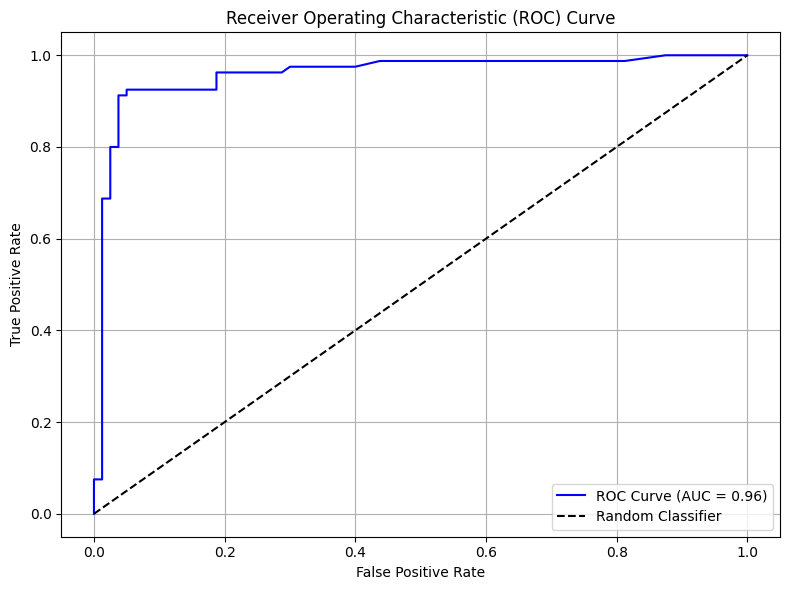

In [14]:
# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:, 1]) #based on class 1
# Calculate AUC
roc_auc = roc_auc_score(y_test, predict_prob[:, 1]) #based on class 1
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Save Rules of Top Model

In [15]:
set_df = heros.get_model_rules(best_model_index)
set_df.to_csv(output_path+'/top_testing_model_rules.csv', index=False)

### Redirect Visualizations to PDF

***
## Visualize Top Model (i.e. Rule-Set) For Interetation
### Specified Features Heatmap

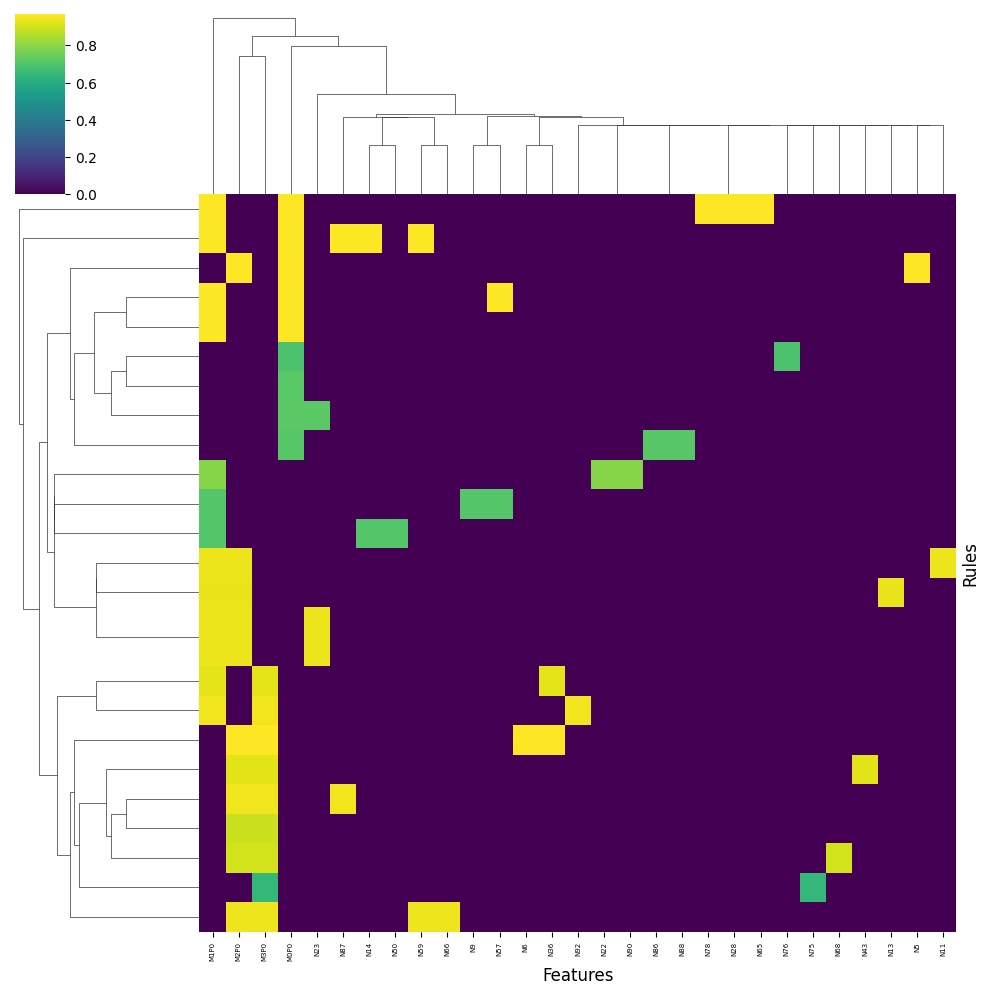

In [16]:
if run_all_cells:
    heros.get_rule_set_heatmap(feature_names, best_model_index, weighting='useful_accuracy', specified_filter=1, display_micro=False, show=True, save=True, output_path=output_path)

### Feature Specification as Network with Feature Co-Occurence as Edges

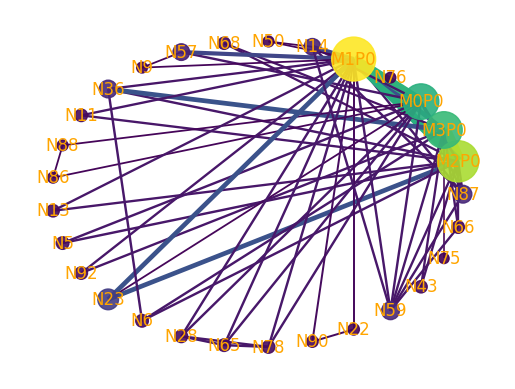

In [17]:
if run_all_cells:
    node_size = 1000
    edge_size = 10
    heros.get_rule_set_network(feature_names, best_model_index, weighting='useful_accuracy', display_micro=False, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=output_path)

### Feature Tracking Scores (Across Training Instances)

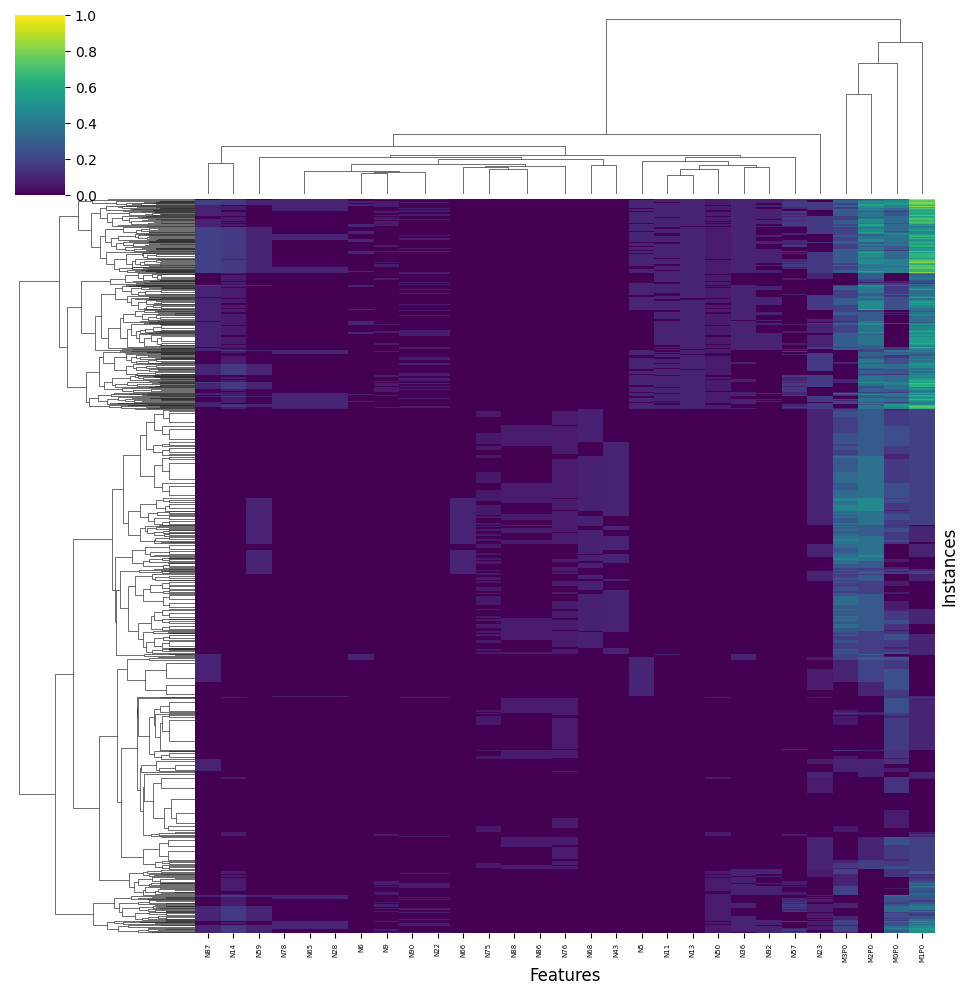

In [18]:
if run_all_cells and feat_track != None:
    heros.run_model_feature_tracking(best_model_index)
    # Save Feature Tracking Scores to .csv
    ft_df = heros.get_model_ft(feature_names)
    ft_df.shape
    ft_df.to_csv(output_path+'/rule_set_'+str(best_model_index)+'_feature_tracking_scores.csv', index=False)
    # Visualize feature tracking scores as clustered heatmap
    heros.get_clustered_model_ft_heatmap(feature_names, specified_filter=1, show=True, save=True, output_path=output_path)


***
## Calculating Top Model Feature Importance Estimates
Using scikit-learn's permutation importance package function.

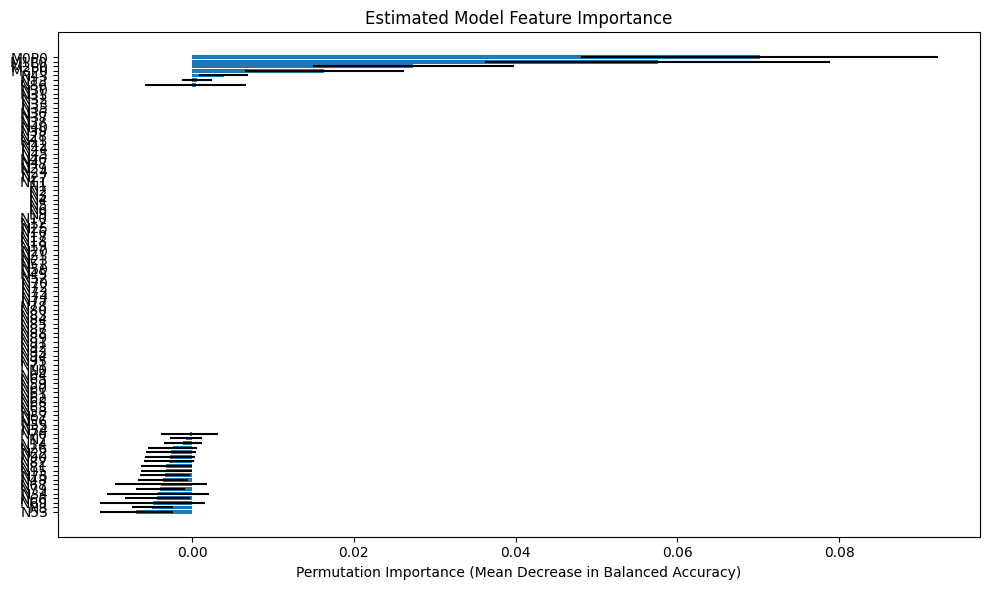

In [19]:
# Run permutation importance
result = permutation_importance(heros, X_test, y_test, n_repeats=100, random_state=random_state, scoring='balanced_accuracy')
# Extract importance means
importances = result.importances_mean
std = result.importances_std
# Sort features by importance
sorted_idx = importances.argsort()[::-1]
# Generate Simple Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], xerr=std[sorted_idx])
plt.xlabel("Permutation Importance (Mean Decrease in Balanced Accuracy)")
plt.title("Estimated Model Feature Importance")
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()

***
## Example Prediction Reasoning Explanation (With Top Model)
When applying the trained models to unlabeled data for prediction, the cells in this section give a basic example of how the prediction reasoning may be explained in clear human interpretable terms. 

In [52]:
# Get example testing instance (with no label) --------------------------------
print("Total Number of Available Testing Instances: "+str(len(X_test)))
target_testing_instance_index = 157 #arbitrarily chosen as an example
target_testing_instance = X_test[target_testing_instance_index]
print("Making Prediction on Testing Instance Index: "+str(target_testing_instance_index))
# Apply prediction to target instance -----------------------------------------
heros.predict_explanation(target_testing_instance, feature_names, whole_rule_pop=False, target_model=best_model_index)

Total Number of Available Testing Instances: 160
Making Prediction on Testing Instance Index: 157
PREDICTION REPORT ------------------------------------------------------------------
Outcome Prediction: 0
Model Prediction Probabilities: {np.int64(0): 0.8459015706300551, np.int64(1): 0.1540984293699448}
Instance Covered by Model: Yes
Number of Matching Rules: 4
PREDICTION EXPLANATION -------------------------------------------------------------
Supporting Rules: --------------------
6 rule copies assert that IF: (M0P0 = 0) AND (M1P0 = 0) THEN: predict outcome '0' with 98.0544747081712% confidence based on 514 matching training instances (35.69% of training instances).
2 rule copies assert that IF: (N76 = 0) AND (M0P0 = 0) THEN: predict outcome '0' with 84.54404945904173% confidence based on 647 matching training instances (44.93% of training instances).
1 rule asserts that IF: (N86 = 1) AND (N88 = 0) AND (M0P0 = 0) THEN: predict outcome '0' with 85.66176470588235% confidence based on 27

Here is an example of a generated heatmap representing all the rules that matched with a particular test instance

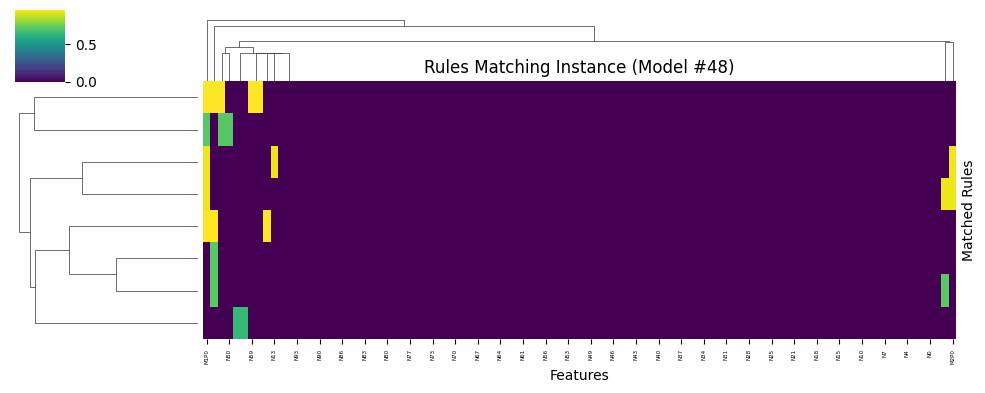

In [21]:
heros.get_rule_set_heatmap_datapoint(target_testing_instance, feature_names, best_model_index)

In [22]:
heros.get_rule_set_network_datapoint(target_testing_instance, feature_names, best_model_index)

Here is an alternative way to output prediction text for the target instance

In [23]:
explanation = heros.explain_prediction_natural(target_testing_instance, feature_names, best_model_index)
print(explanation)

The model predicted '1' with confidence 84.06%.
It matched 8 rules in the chosen model.

The supporting rules (sorted by reliability, most reliable first):
  • Rule 20 (reliability 0.96): N14, N59, N87, M0P0 and M1P0  
    – This outscored the strongest opposing rule by **0.32**
  • Rule 12 (reliability 0.96): N57, M0P0 and M1P0  
    – This outscored the strongest opposing rule by **0.32**
  • Rule 21 (reliability 0.94): N23, M1P0 and M2P0  
    – This outscored the strongest opposing rule by **0.29**
  • Rule 10 (reliability 0.94): N13, M1P0 and M2P0  
    – This outscored the strongest opposing rule by **0.29**
  • Rule 19 (reliability 0.72): N23 and M0P0  
    – This outscored the strongest opposing rule by **0.08**
  • Rule 2 (reliability 0.71): M0P0  
    – This outscored the strongest opposing rule by **0.07**
  • Rule 3 (reliability 0.71): N14, N50 and M1P0  
    – This outscored the strongest opposing rule by **0.07**

 The top contradictory rules (sorted by reliability, most 

In this example, we are using Groq to run our text output through an LLM. To do this, we are passing an api key, which authenticates our session. I have used my personal token in this example. Essentially, what this does is it tells Groq that we are accessing their servers with an authenticated session and that we are allowed to query their LLM service.

In [24]:
api_key = "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"

client = Groq(api_key=api_key)


Here is the function which takes in a narrative string (raw text output from heros), and takes in an optional parameter of the specific LLM model (in this case the default is llama 3.3), along with a max_token parameter, which is the maximum for how much text you can pass to the LLM at once.

The function consists of two parts: the system prompt and the narrative. The system prompt is basically added on before our raw text output narrative, and tells the LLM the context of what we want to do. In this case, we are telling it how we want the output to look like, and then we pass in the actual narrative after that prompt. We then pass this entire block of text into the LLM, and return the response as a string.

In [25]:
def text_to_natural_language(narrative: str,
                             model: str = "llama-3.3-70b-versatile",
                             max_tokens: int = 512) -> str:
    """
    Rewrite the technical narrative into clear, concise prose
    using Groq's Chat Completions API. Falls back to the original
    narrative if the API errors.
    """
    prompt = (
        "Rewrite the following technical model explanation into a clear, "
        "concise paragraph for a non-technical audience. Give details on how "
        "each of the rules contributed (or didn't contribute if it is a contradictory rule)  "
        "and why it decided on the decision it did. Be specific on what factors the rules took "
        "into account and which factors were similar and different. Make sure to start with the decision "
        "it made and the confidence it had in that decision. Support all claims with data and don't just be general:\n\n"
        + narrative
    )

    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user",   "content": prompt}
        ],
        max_tokens=max_tokens
    )
    LLM_text = completion.choices[0].message.content
    wrapped = textwrap.fill(LLM_text, width=80)
    return wrapped




You can see below the output of the LLM-processed text (in this example we passed in the newly formatted input text above)

In [53]:
NLP_explanation = text_to_natural_language(explanation)
print("Natural Language Explanation of Prediction:")
print(NLP_explanation)

Natural Language Explanation of Prediction:
The model made a prediction of '1' with a confidence level of 84.06%, indicating
that it was reasonably certain about its decision. This prediction was supported
by eight rules, with the top rules being highly reliable, having scores of 0.96
and 0.94. Specifically, Rule 20 and Rule 12, with reliability scores of 0.96,
were the most influential, taking into account factors such as N14, N59, N87,
M0P0, and M1P0, as well as N57, M0P0, and M1P0, respectively. These rules
outscored the strongest opposing rule by 0.32, demonstrating their significant
contribution to the final decision. The next most reliable rules, Rule 21 and
Rule 10, also had high reliability scores of 0.94 and took into account similar
factors such as M1P0 and M2P0. In contrast, the top contradictory rule, Rule 23,
had a lower reliability score of 0.64 and considered different factors such as
N75 and M3P0, but its influence was negligible, being 0.00 below the top
supporting rul

Here, we are printing the LLM output (with the same system prompt) that results from passing in the original formatting of the data. We have printed first the raw input, and then the LLM processed data afterwards.

In [27]:
print("\n\nRaw Explanation of Prediction:")
raw_explanation = heros.predict_explanation_string(target_testing_instance, feature_names)
print("\n\nLLM Explanation of Prediction:")
print(text_to_natural_language(raw_explanation))




Raw Explanation of Prediction:
13 rule copies assert that IF: (M1P0 = 1) THEN: predict outcome '1' with 85.3211009174312% confidence based on 654 matching training instances (45.42% of training instances).
10 rule copies assert that IF: (M0P0 = 1) AND (M2P0 = 1) THEN: predict outcome '1' with 97.71689497716895% confidence based on 438 matching training instances (30.42% of training instances).
6 rule copies assert that IF: (M0P0 = 1) THEN: predict outcome '1' with 85.67073170731707% confidence based on 656 matching training instances (45.56% of training instances).
1 rule asserts that IF: (N13 = 0) AND (N50 = 0) AND (M2P0 = 1) THEN: predict outcome '1' with 86.48180242634315% confidence based on 577 matching training instances (40.07% of training instances).
1 rule asserts that IF: (N77 = 0) AND (M0P0 = 1) AND (M1P0 = 1) THEN: predict outcome '1' with 96.875% confidence based on 384 matching training instances (26.67% of training instances).
1 rule asserts that IF: (N14 = 0) AND (M0P

In [28]:
collector.save_pdf('output_report.pdf')
collector.restore()   # if you want to go back to normal behaviour

📄 All figures saved to output_report.pdf


***
## Visualize Rule and Model Population Pareto Fronts
### **Rule Population**

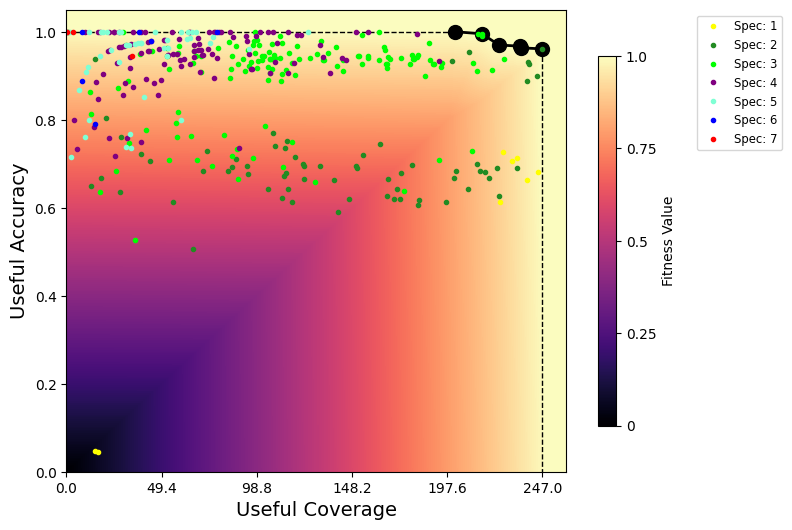

In [29]:
if run_all_cells:
    resolution = 500
    plot_rules = True
    color_rules = True
    heros.get_rule_pareto_landscape(resolution, heros.rule_population, plot_rules, color_rules,show=True,save=True,output_path=output_path)

### **Model Population**

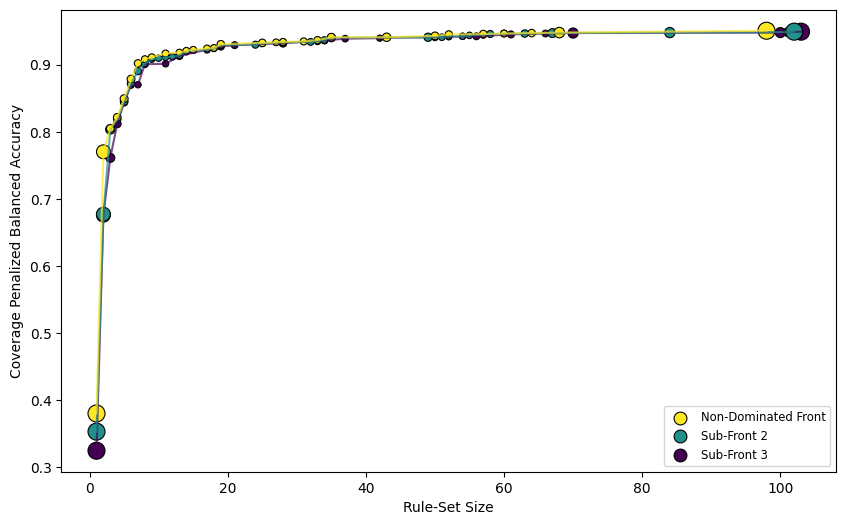

In [30]:
if run_all_cells:
    resolution = 500
    plot_models = True
    heros.get_model_pareto_fronts(show=True,save=True,output_path=output_path)

***
## Saving Rule and Model Populations as Output

In [31]:
# Save Rule Population as .csv
rule_pop_df = heros.get_pop()
rule_pop_df.to_csv(output_path+'/rule_pop.csv', index=False)
# Save Model Population as .csv
model_pop_df = heros.get_model_pop()
model_pop_df.to_csv(output_path+'/model_pop.csv', index=False)

***
## Save and Visualize Learning Performance across Phase I and Phase 2 Training Iterations
### **Phase I (Rule Learning)**

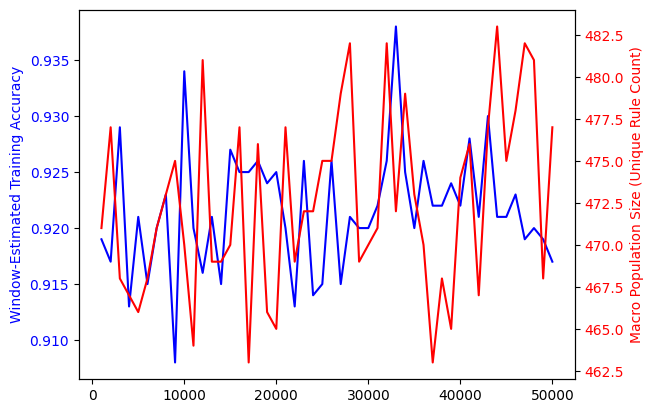

In [32]:
# Save Phase 1 Rule Training Performance Estimates to .csv
rule_tracking_df = heros.get_performance_tracking()
rule_tracking_df.to_csv(output_path+'/rule_pop_tracking.csv', index=False)
# Plot Rule Learning Tracking
heros.get_rule_tracking_plot(show=True,save=True,output_path=output_path)

### **Phase II (Model Learning)**

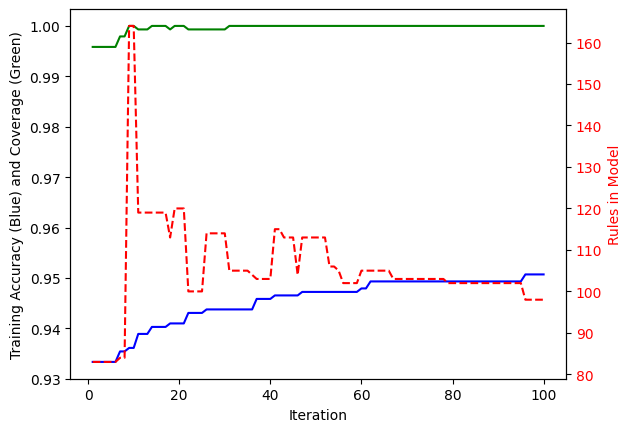

In [33]:
model_tracking_df = heros.get_model_performance_tracking()
model_tracking_df.to_csv(output_path+'/model_tracking.csv', index=False)
# Plot Model Learning Tracking
heros.get_model_tracking_plot(show=True,save=True,output_path=output_path)

***
## Saving Other Outputs
### Pickle Trained HEROS Object (For Future Use)

In [34]:
# Pickle HEROS object
with open(output_path+'/heros.pickle', 'wb') as f:
    pickle.dump(heros, f)
# Load previously pickled HEROS Object
with open(output_path+'/heros.pickle', 'rb') as f:
    heros = pickle.load(f)

### Document HEROS Run Paramter Settings

In [35]:
heros.save_run_params(output_path+'/heros_run_parameters.txt')

### Save Run Time Summary

In [36]:
time_df = heros.get_runtimes()
time_df.to_csv(output_path+'/runtimes.csv', index=False)
print(time_df)

       Global    Phase 1     Phase 2  Rule Initialization  Rule Covering  \
0  302.264738  78.735173  223.414855             0.099479       0.010231   

   Rule Equality  Rule Matching  Rule Evaluation  Feature Tracking  \
0       5.411498        6.25089        90.723963               0.0   

   Rule Subsumption  Rule Selection  Rule Mating  Rule Deletion  \
0          1.131448        2.023462     5.711435       9.673426   

   Rule Compaction  Rule Prediction  
0         0.016187         1.672155  


***
## Visual Interpretation and Predictions With the Whole Phase I Rule Population
### Vizualize Rule Population (Feature Specification) as a Rule-Clustered Heatmap (With Optional Rule-Weighting)
Parameters:
* *feature_names*: a list of feature names for the entire training dataset (given in original dataset order)
*  *weighting*: indicates what (if any) weighting is applied to individual rules for the plot ('useful_accuracy', 'fitness', None)
*  *specified_filter*: the number of times a given feature must be specified in rules of the population to be included in the plot (must be a positive integer or None)
*  *display_micro*: controls whether or not additional copies of rules (based on rule numerosity) should be included in the heatmap (True or False) 
*  *show*: indicates whether or not to show the plot (True or False)
*  *save*: indicates whether or not to save the plot to a specified path/filename (True or False)
*  *output_path*: a valid folder path within which to save the plot (str of folder path)
*  *data_name*: a unique name precursor to give to the plot (str)

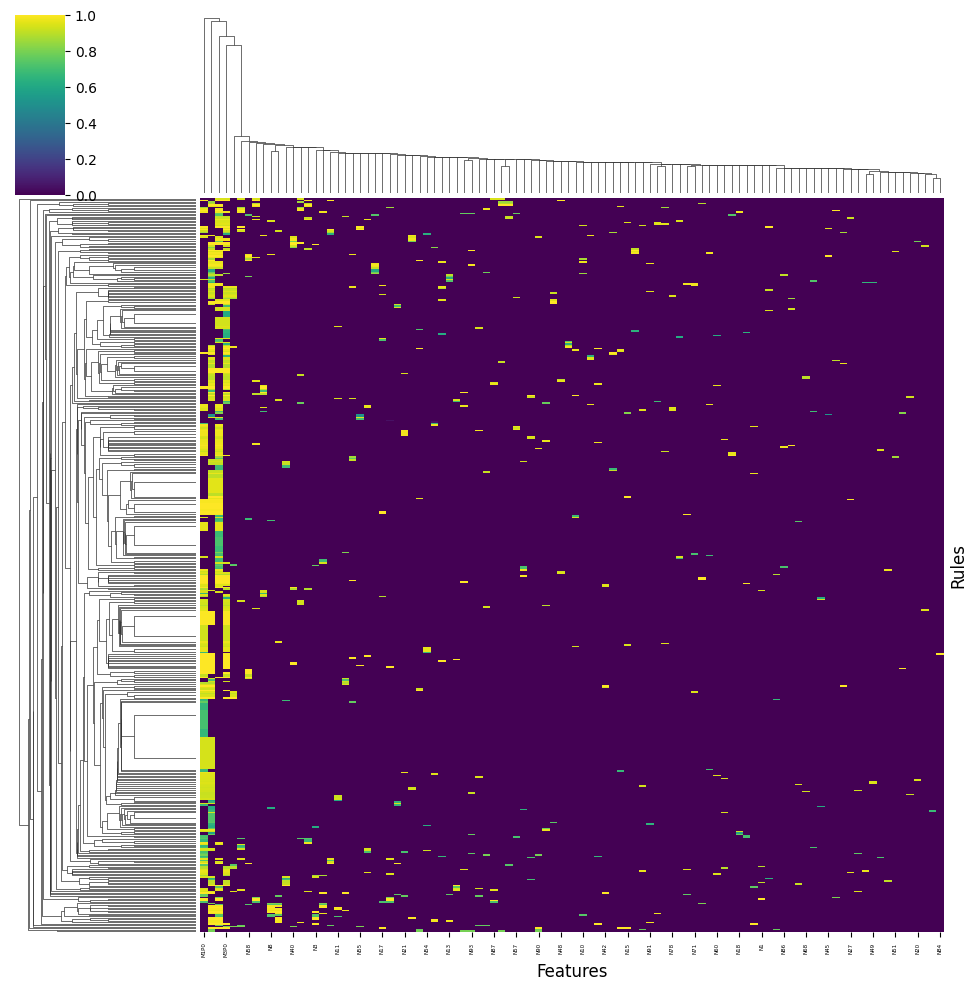

In [37]:
if run_all_cells:
    heros.get_rule_pop_heatmap(feature_names, weighting='useful_accuracy', specified_filter=1, display_micro=True, show=True, save=True, output_path=output_path)

### Vizualize Rule Population (Feature Specification) as a Network (With Optional Rule-Weighting)

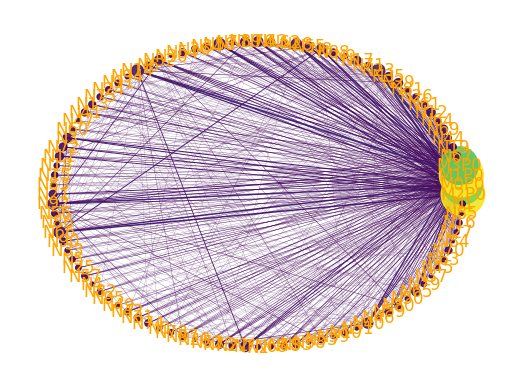

In [38]:
if run_all_cells:
    node_size = 1000
    edge_size = 10
    weighting = 'useful_accuracy'# 'useful_accuracy', 'fitness', None
    display_micro = True
    heros.get_rule_pop_network(feature_names, weighting=weighting, display_micro=display_micro, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=output_path)


### Vizualize Rule Population Feature Tracking Scores

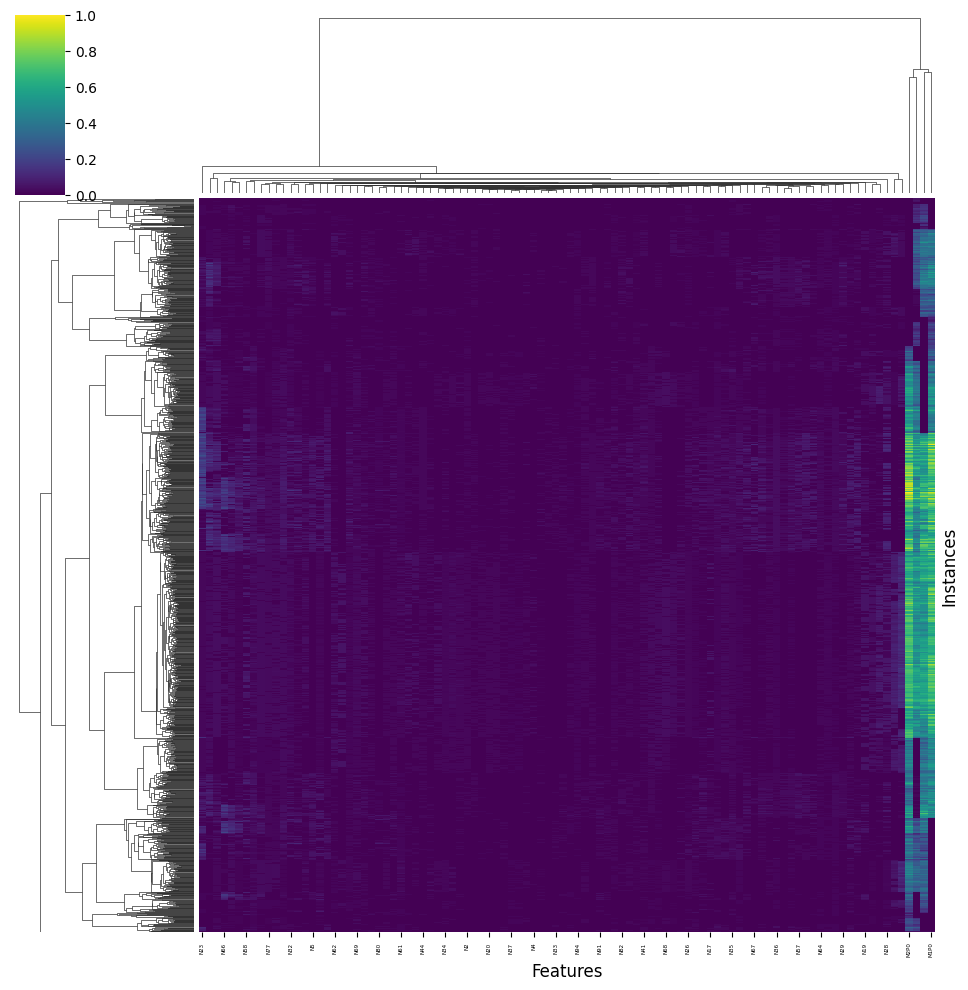

In [39]:
# Save Feature Tracking Scores to .csv
if heros.feat_track != None:
    ft_df = heros.get_ft(feature_names)
    ft_df.shape
    ft_df.to_csv(output_path+'/feature_tracking_scores.csv', index=False)
# Visualize clustered heatmap of feature tracking scores across all training instances
if heros.feat_track != None and run_all_cells:
    heros.get_clustered_ft_heatmap(feature_names, show=True, save=True, output_path=output_path)

### Prediction with Whole Phase I Rule Population

In [40]:
predictions = heros.predict(X_test,whole_rule_pop=True)
print("HEROS Whole Rule Population Testing Data Performance Report:")
print(classification_report(predictions, y_test, digits=8))

HEROS Whole Rule Population Testing Data Performance Report:
              precision    recall  f1-score   support

           0  0.92500000 0.88095238 0.90243902        84
           1  0.87500000 0.92105263 0.89743590        76

    accuracy                      0.90000000       160
   macro avg  0.90000000 0.90100251 0.89993746       160
weighted avg  0.90125000 0.90000000 0.90006254       160



***
## Testing Evaluation with Top Default Model or Custom Selected Model
### **Top Default Model** (i.e. selected as model on front with highest training accuracy)
Ranked by accuracy, then coverage, then rule-count (as tie-breakers)

In [41]:
# Save Top Model selected by Default from the Front (Model on front with highest training accuracy)
set_df = heros.get_model_rules() #returns top training model by default based on balanced accuracy, then covering, then rule-set size.
set_df.to_csv(output_path+'/top_default_model_rules.csv', index=False)
print(set_df)
# Model Predictions and Evaluation using this 'Default' top model
predictions = heros.predict(X_test)
print("HEROS Top 'Default' Model Testing Data Performance Report:")
print(classification_report(predictions, y_test, digits=8))

           Condition Indexes    Condition Values  Action  Numerosity  \
0                   [76, 96]              [0, 0]       0           2   
1                       [96]                 [1]       1           6   
2                   [23, 96]              [0, 1]       1           1   
3   [35, 53, 70, 90, 93, 98]  [0, 0, 0, 1, 0, 1]       1           1   
4                [5, 96, 98]           [0, 1, 1]       1           1   
..                       ...                 ...     ...         ...   
93              [69, 97, 98]           [1, 1, 1]       1           1   
94                  [75, 99]              [0, 0]       0           1   
95          [42, 96, 97, 99]        [0, 1, 1, 1]       1           1   
96                  [26, 96]              [1, 1]       1           1   
97          [84, 97, 98, 99]        [1, 1, 1, 1]       1           1   

     Fitness  Useful Accuracy  Useful Coverage  Accuracy  Match Cover  \
0   0.902061         0.690881            223.5  0.845440      

### **Custom Selected Model** (Any Model in Trained Model Population)
The model index represents the index of the model in the final trained model population.

In [42]:
# Save Top Model selected by Default from the Front (Model on front with highest training accuracy)
desired_model_index = 1
set_df = heros.get_model_rules(index=desired_model_index) #returns top training model by default based on balanced accuracy, then covering, then rule-set size.
print(set_df)
# Model Predictions and Evaluation using this 'Default' top model
predictions = heros.predict(X_test,whole_rule_pop=False,target_model=desired_model_index)
print("HEROS Top 'Default' Model Testing Data Performance Report:")
print(classification_report(predictions, y_test, digits=8))

        Condition Indexes Condition Values  Action  Numerosity   Fitness  \
0        [56, 87, 98, 99]     [0, 0, 1, 1]       1           1  0.965942   
1            [77, 96, 97]        [0, 1, 1]       1           1  0.934957   
2        [28, 60, 98, 99]     [1, 0, 1, 1]       1           1  0.952033   
3     [8, 12, 58, 96, 98]  [0, 1, 1, 1, 1]       1           1  0.961724   
4    [28, 73, 75, 97, 98]  [1, 0, 0, 1, 1]       1           1  0.966789   
..                    ...              ...     ...         ...       ...   
97           [86, 88, 96]        [1, 0, 0]       0           1  0.708904   
98    [8, 58, 66, 89, 96]  [0, 0, 0, 0, 1]       1           1  0.731641   
99           [36, 96, 97]        [0, 1, 1]       1           1  0.937581   
100              [96, 98]           [1, 1]       1          10  0.956955   
101          [78, 96, 97]        [0, 1, 1]       1           1  0.940276   

     Useful Accuracy  Useful Coverage  Accuracy  Match Cover  Correct Cover  \
0       

***
## Evaluation of Stored Rule Populations (At User-Specified Iteration Checkpoints)
To facilitate comparing algorithm performance at earlier learning iterations.

In [43]:
if stored_rule_iterations != None:
    rule_iteration_list = [int(x) for x in stored_rule_iterations.split(',')]
    for iterations in rule_iteration_list:
        print("Rule population evaluation at iteration "+str(iterations))
        print("Run Time: "+str(heros.timer.rule_time_archive[iterations]))
        predictions = heros.predict(X_test,whole_rule_pop=True,rule_pop_iter=iterations)
        print(classification_report(predictions, y_test, digits=8))

Rule population evaluation at iteration 500
Run Time: 0.8919060230255127
              precision    recall  f1-score   support

           0  0.92500000 0.87058824 0.89696970        85
           1  0.86250000 0.92000000 0.89032258        75

    accuracy                      0.89375000       160
   macro avg  0.89375000 0.89529412 0.89364614       160
weighted avg  0.89570313 0.89375000 0.89385386       160

Rule population evaluation at iteration 1000
Run Time: 1.7372770309448242
              precision    recall  f1-score   support

           0  0.92500000 0.89156627 0.90797546        83
           1  0.88750000 0.92207792 0.90445860        77

    accuracy                      0.90625000       160
   macro avg  0.90625000 0.90682209 0.90621703       160
weighted avg  0.90695313 0.90625000 0.90628297       160

Rule population evaluation at iteration 5000
Run Time: 8.02581000328064
              precision    recall  f1-score   support

           0  0.92500000 0.87058824 0.89696970

***
## Evaluation of Stored Top Model (At User-Specified Iteration Checkpoints)
To facilitate comparing algorithm performance at earlier learning iterations.
### **With Default Top Model**

In [44]:
if stored_model_iterations != None:
    model_iteration_list = [int(x) for x in stored_model_iterations.split(',')]
    for iterations in model_iteration_list:
        print("Top default model evaluation at iteration "+str(iterations))
        print("Run Time: "+str(heros.timer.model_time_archive[iterations]))
        predictions = heros.predict(X_test,whole_rule_pop=False,model_pop_iter=iterations)
        print(classification_report(predictions, y_test, digits=8))

Top default model evaluation at iteration 10
Run Time: 31.100019693374634
              precision    recall  f1-score   support

           0  0.88750000 0.89873418 0.89308176        79
           1  0.90000000 0.88888889 0.89440994        81

    accuracy                      0.89375000       160
   macro avg  0.89375000 0.89381153 0.89374585       160
weighted avg  0.89382812 0.89375000 0.89375415       160

Top default model evaluation at iteration 50
Run Time: 115.15056586265564
              precision    recall  f1-score   support

           0  0.90000000 0.91139241 0.90566038        79
           1  0.91250000 0.90123457 0.90683230        81

    accuracy                      0.90625000       160
   macro avg  0.90625000 0.90631349 0.90624634       160
weighted avg  0.90632812 0.90625000 0.90625366       160

Top default model evaluation at iteration 100
Run Time: 223.3946943283081
              precision    recall  f1-score   support

           0  0.87500000 0.90909091 0.89171

### **With Top Model Selected From Pareto-Front Using Testing Data**

In [45]:
if stored_model_iterations != None:
    model_iteration_list = [int(x) for x in stored_model_iterations.split(',')]
    for iterations in model_iteration_list:
        print('---------------------------------------------------------------------------------------------')
        print("Top model evaluation at iteration "+str(iterations))
        print("Run Time: "+str(heros.timer.model_time_archive[iterations]))
        iter_best_model_index = heros.auto_select_top_model(X_test,y_test,verbose=True,model_pop_iter=iterations)
        predictions = heros.predict(X_test,whole_rule_pop=False, target_model=iter_best_model_index)
        print(classification_report(predictions, y_test, digits=8))


---------------------------------------------------------------------------------------------
Top model evaluation at iteration 10
Run Time: 31.100019693374634
32 non-dominated models on Pareto-front.
----------------------------------------
Model testing accuracies: [np.float64(0.89375), np.float64(0.8875), np.float64(0.875), np.float64(0.9), np.float64(0.90625), np.float64(0.9125), np.float64(0.875), np.float64(0.9), np.float64(0.89375), np.float64(0.925), np.float64(0.9125000000000001), np.float64(0.8875), np.float64(0.90625), np.float64(0.9125), np.float64(0.90625), np.float64(0.8875), np.float64(0.89375), np.float64(0.86875), np.float64(0.89375), np.float64(0.8999999999999999), np.float64(0.86875), np.float64(0.875), np.float64(0.9125), np.float64(0.8875), np.float64(0.8875), np.float64(0.90625), np.float64(0.89375), np.float64(0.825), np.float64(0.825), np.float64(0.80625), np.float64(0.7875), np.float64(0.71875)]
Model testing coverages: [np.float64(1.0), np.float64(1.0), np.flo